In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, 

####Read in sample metadata and OTU table

In [3]:
%%R 
physeq = import_biom("data/otu_table_JSON_wtax.biom", "data/otusn_JSON.tree")
print(physeq)
sample.data = import_qiime_sample_data("data/JSON_mapping_file.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
print(physeq)
physeq = prune_samples((physeq.md$Treatment %in% c("NTH", "PTH")),physeq) 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
sample_data() Sample Data:       [ 82 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]


In [23]:
%%R
get_l2fc = function(physeq.obj, Month) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Month == Month), physeq.obj)
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    r = results(dds, independentFiltering = TRUE, lfcThreshold = 0, cooksCutoff = FALSE, pAdjustMethod = "BH")
    r$OTU = rownames(r)
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [24]:
%%R
m = expand.grid(Month = c("July", "September", "October", "November"))
m

      Month
1      July
2 September
3   October
4  November


In [25]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(m, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))
df.l2fc

Source: local data frame [39,024 x 13]

   Month       OTU log2FoldChange     lfcSE      padj    Rank1
1   July  OTU.7316             NA        NA        NA Bacteria
2   July  OTU.9404             NA        NA        NA Bacteria
3   July  OTU.5128      1.1641942 1.1874641        NA Bacteria
4   July OTU.10969             NA        NA        NA Bacteria
5   July OTU.10860             NA        NA        NA Bacteria
6   July   OTU.726     -1.1252044 0.9260669 0.5801599 Bacteria
7   July  OTU.1606     -0.1631967 0.5863220 0.9304422 Bacteria
8   July OTU.13105     -1.6761938 1.3611337        NA Bacteria
9   July  OTU.1450     -1.4590867 0.7900524 0.3272301 Bacteria
10  July  OTU.3374      1.0967707 1.1500474 0.6897054 Bacteria
..   ...       ...            ...       ...       ...      ...
Variables not shown: Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr),
  Rank6 (fctr), Rank7 (fctr), Rank8 (fctr)


In [12]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     meanl2fc
1 -0.05374794


In [13]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
1 1.322069


####Function arguments

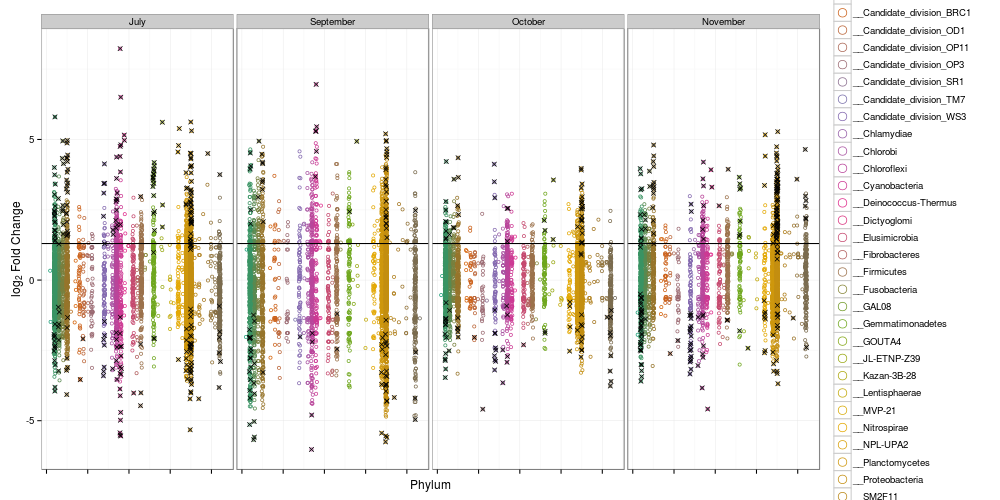

In [26]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_wrap(~Month, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [27]:
%%R 
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank2, Month) 

In [28]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "unknown/non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "NTH responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange < 0] = "PTH responder"

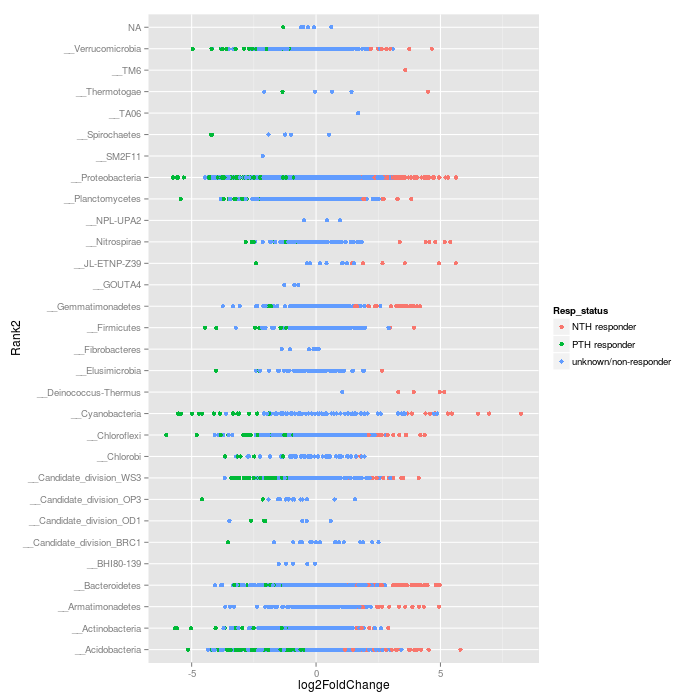

In [29]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

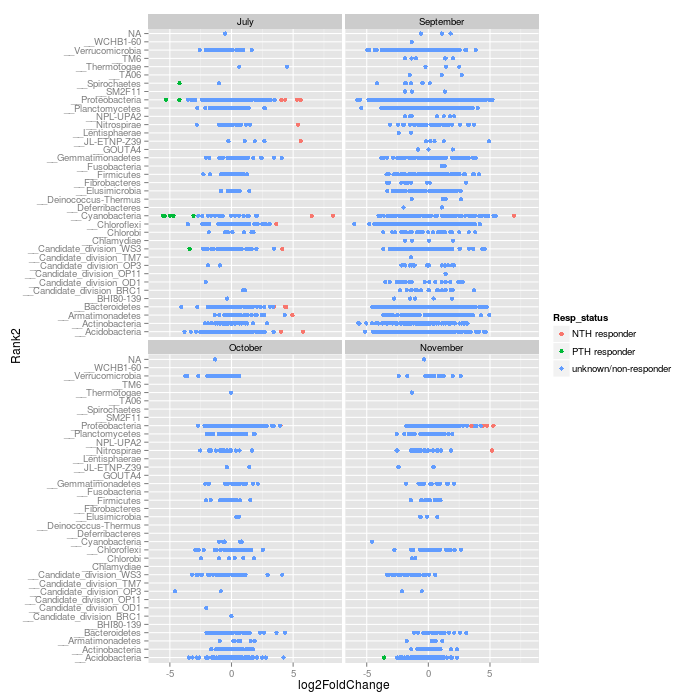

In [22]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

## Blasting against Living Tree Project db

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [ ]:
from cogent import LoadSeqs, DNA


In [ ]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

In [ ]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [ ]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

In [ ]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

In [ ]:
from IPython.display import Image
import pandas.rpy.common as com

In [ ]:
%%R
library(data.table)
library(dplyr)

In [ ]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [ ]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

In [ ]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [ ]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)

In [ ]:
%%R
joined_df = filter(joined_df, name != "NA")

In [ ]:
%%R
dim(joined_df)

In [ ]:
df = com.load_data("joined_df")

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")